# Setup - GPU Solver Examples

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, sys
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jfi import jaxm

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
import pmpc
from pmpc.experimental import scp_solve, solve_problems

### Define dynamics

In [3]:
def car(x, u, p):
    """
    unicycle car dynamics, 4 states, 2 actions
    x1: position x
    x2: position y
    x3: speed (local frame)
    x4: orientation angle

    u1: acceleration
    u2: turning speed (independent of velocity)
    """
    assert x.shape[-1] == 4 and u.shape[-1] == 2
    v_scale, w_scale, T = p[..., 0], p[..., 1], p[..., 2]
    eps = 1e-3
    u1, u2 = v_scale * u[..., 0], w_scale * -u[..., 1]
    u1 = u1 + jaxm.where(u1 >= 0.0, eps, -eps)
    u2 = u2 + jaxm.where(u2 >= 0.0, eps, -eps)

    x0, y0, v0, th0 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]
    xp1 = (
        x0
        + (
            u2 * jaxm.sin(T * u2 + th0) * v0
            + T * u1 * u2 * jaxm.sin(T * u2 + th0)
            + u1 * jaxm.cos(T * u2 + th0)
        )
        / u2**2
        - (jaxm.sin(th0) * u2 * v0 + jaxm.cos(th0) * u1) / u2**2
    )
    xp2 = (
        y0
        - (
            u2 * jaxm.cos(T * u2 + th0) * v0
            - u1 * jaxm.sin(T * u2 + th0)
            + T * u1 * u2 * jaxm.cos(T * u2 + th0)
        )
        / u2**2
        + (jaxm.cos(th0) * u2 * v0 - jaxm.sin(th0) * u1) / u2**2
    )
    xp3 = v0 + T * u1
    xp4 = T * u2 + th0
    xp = jaxm.stack([xp1, xp2, xp3, xp4], -1)
    return xp


def fx_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda x: jaxm.sum(car(x, u, p), sum_dims))(x), 0, -2)


def fu_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda u: jaxm.sum(car(x, u, p), sum_dims))(u), 0, -2)


@jaxm.jit
def f_fx_fu_fn(x, u):
    p = jaxm.to(jaxm.array([1.0, 1.0, 0.3]), dtype=x.dtype)
    return car(x, u, p), fx_(x, u, p), fu_(x, u, p)
    
SMOOTH_ALPHA = 1e2 # smooth constraints refinement parameter, higher is closer to hard constraints


---
# Specify the problem as a list of problems

In [45]:
N, xdim, udim = 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=1e1, reg_u=1e0, max_it=50)
# WE ARE USING GPU HERE ############################################################################
opts["device"] = "cuda"
opts["solver_settings"] = dict(smooth_alpha=SMOOTH_ALPHA)  # GPU supports only smooth constraints
# WE ARE USING GPU HERE ############################################################################
problem = dict(f_fx_fu_fn=f_fx_fu_fn, Q=Q, R=R, x0=x0)
problem = dict(problem, X_ref=X_ref, U_ref=U_ref, X_prev=X_prev, U_prev=U_prev, u_l=u_l, u_u=u_u)
problem = dict(problem, **opts)
M = 1000
# problems = [dict(problem, X_ref=problem["X_ref"] + jaxm.randn((N, xdim))) for _ in range(M)]
problems = [dict(problem, X_ref=problem["X_ref"] + (i != 0) * 1e-1 * jaxm.randn((1, xdim))) for i in range(M)]


In [46]:
# let's solve the problem
split = False
X, U, data = solve_problems(problems, split=split)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  1.384e-01 |  1.038e+01 |  1.864e+00 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0002 |  2.705e-01 |  1.230e+00 |  1.064e+00 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0003 |  3.930e-01 |  1.161e+00 |  1.038e+00 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0004 |  5.172e-01 |  9.950e-01 |  7.175e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0005 |  6.393e-01 |  9.446e-01 |  6.623e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0006 |  7.615e-01 |  9.098e-01 |  4.521e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0007 |  8.839e-01 |  8.825e-01 |  5.300e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0008 |  1.006e+00 |  8.601e-01 |  5.989e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0009 |  1.133e+00 |  8.417e-01 |  6.364e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0010 |  1.257e+00 |  8.255

### Visualize the results

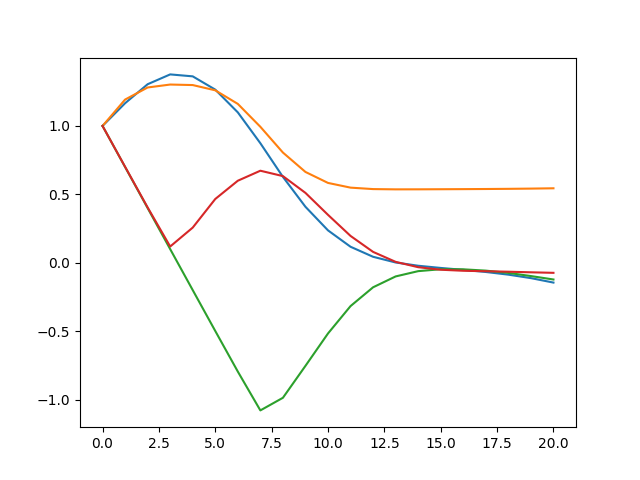

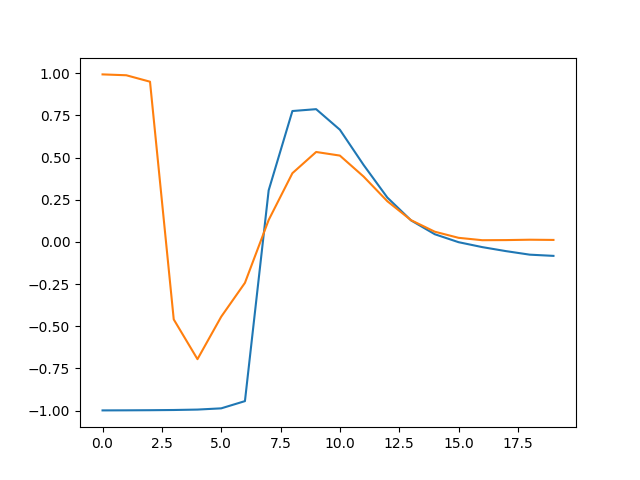

In [47]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X[idx, :, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U[idx, :, r], label=f"u{r}")
plt.show()

---
# Specify a problem as a batch

In [7]:
M, N, xdim, udim = 1000, 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u = [
    np.tile(z, (M,) + (1,) * z.ndim) for z in [Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u]
]
X_ref = np.stack([problem["X_ref"] for problem in problems], 0)

opts = dict(verbose=True, reg_x=3e0, reg_u=1e0, max_it=50)
# WE ARE USING GPU HERE ############################################################################
opts["device"] = "cuda"
opts["solver_settings"] = dict(smooth_alpha=SMOOTH_ALPHA)  # GPU supports only smooth constraints
# WE ARE USING GPU HERE ############################################################################
args = dict(f_fx_fu_fn=f_fx_fu_fn, Q=Q, R=R, x0=x0)
args = dict(args, X_ref=X_ref, U_ref=U_ref, X_prev=X_prev, U_prev=U_prev, u_l=u_l, u_u=u_u)

### Solve the problem

In [8]:
X, U, data = scp_solve(**args, **opts, return_solhist=True)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  2.400e+00 |  3.886e+00 |  1.864e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0002 |  2.541e+00 |  1.126e+00 |  8.947e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0003 |  2.664e+00 |  9.232e-01 |  9.932e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0004 |  2.787e+00 |  8.568e-01 |  1.005e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0005 |  2.913e+00 |  8.124e-01 |  8.489e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0006 |  3.039e+00 |  7.868e-01 |  7.238e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0007 |  3.163e+00 |  7.715e-01 |  6.483e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0008 |  3.287e+00 |  7.622e-01 |  7.442e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0009 |  3.412e+00 |  7.560e-01 |  8.265e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0010 |  3.535e+00 |  7.515

### Visualize the results

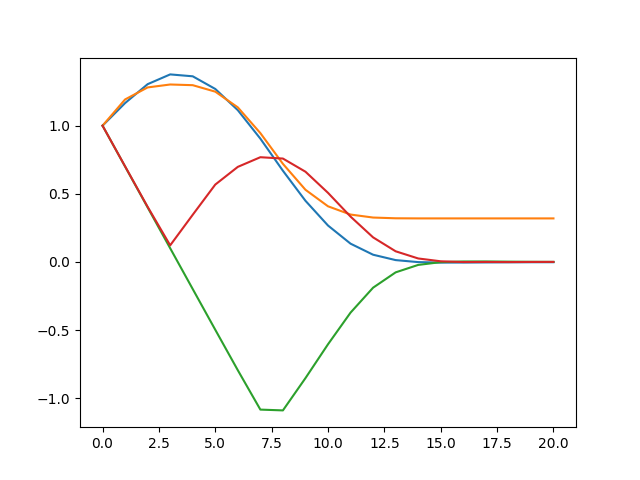

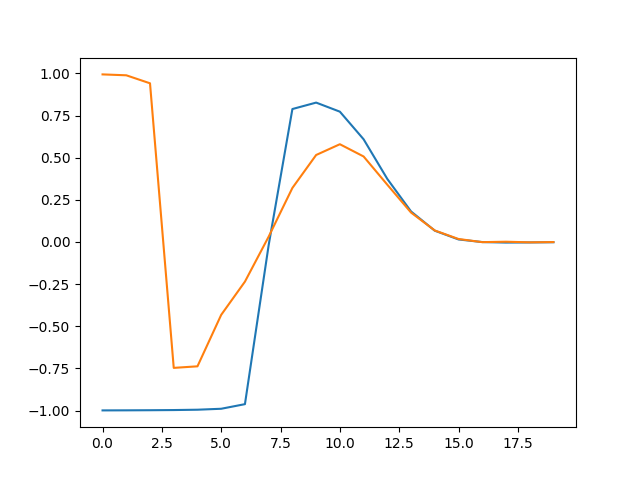

In [9]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X[idx, :, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U[idx, :, r], label=f"u{r}")
plt.show()

# CPU version for a quick check

In [10]:
opts["solver_settings"] = dict(smooth_alpha=SMOOTH_ALPHA)
# select only the first problem from the batch arguments
cpu_args = {
    k: v[0, ...] if hasattr(v, "shape") and len(v.shape) > 0 else v
    for k, v in args.items()
    if k in set.union(pmpc.SOLVE_KWS, {"Q", "R", "x0", "f_fx_fu_fn"})
}
cpu_opts = {k: v for k, v in opts.items() if k in pmpc.SOLVE_KWS}

In [13]:
X2, U2, data = pmpc.solve(**cpu_args, **cpu_opts)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  4.368e-03 |  2.206e+00 |  1.944e+00 |  3.000e+00 |  1.000e+00 |
| 0002 |  7.812e-03 |  1.998e+00 |  3.095e-01 |  3.000e+00 |  1.000e+00 |
| 0003 |  1.118e-02 |  1.853e+00 |  2.418e-01 |  3.000e+00 |  1.000e+00 |
| 0004 |  1.443e-02 |  1.761e+00 |  1.301e-01 |  3.000e+00 |  1.000e+00 |
| 0005 |  1.794e-02 |  1.709e+00 |  1.596e-01 |  3.000e+00 |  1.000e+00 |
| 0006 |  2.128e-02 |  1.676e+00 |  1.498e-01 |  3.000e+00 |  1.000e+00 |
| 0007 |  2.501e-02 |  1.655e+00 |  1.365e-01 |  3.000e+00 |  1.000e+00 |
| 0008 |  2.858e-02 |  1.642e+00 |  1.226e-01 |  3.000e+00 |  1.000e+00 |
| 0009 |  3.205e-02 |  1.632e+00 |  1.092e-01 |  3.000e+00 |  1.000e+00 |
| 0010 |  3.490e-02 |  1.626e+00 |  9.693e-02 |  3.000e+00 |  1.000e+00 |
| 0011 |  3.738e-02 |  1.622e+00 |  8.

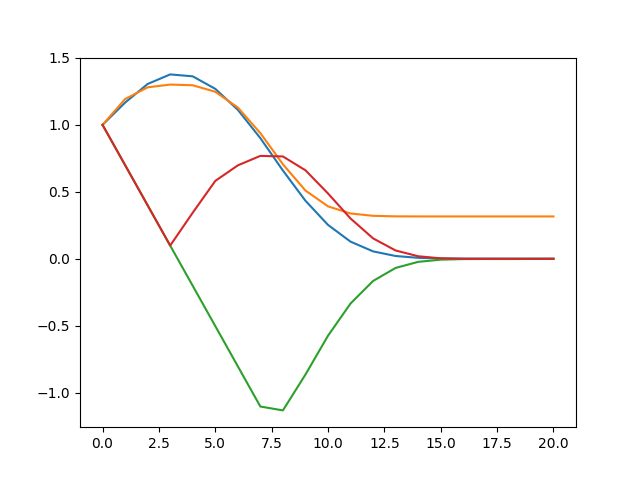

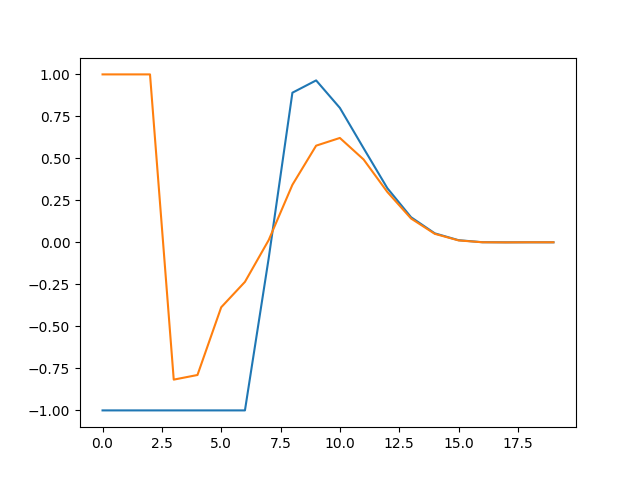

In [14]:
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X2[:, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U2[:, r], label=f"u{r}")
plt.show()